In [88]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from itertools import cycle, islice
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch import no_grad
import tqdm
plt.style.use('seaborn') 

# Code for rebuttal analysis

python tda/test_simple_ex.py --architecture toy_mlp4 --dataset CircleToy --epochs 150 --attack_type PGD --embedding_type PersistentDiagram --kernel_type SlicedWasserstein --thresholds 0:0:0.6_1:0:0.6 --threshold_strategy UnderoptimizedMagnitudeIncrease --dataset_size 1000

python tda/experiments/ours/our_binary.py --architecture toy_mlp3 --dataset CircleToy --epochs 100 --attack_type PGD --embedding_type PersistentDiagram --kernel_type SlicedWasserstein --thresholds 0:0:0.6_1:0:0.6 --threshold_strategy UnderoptimizedMagnitudeIncrease --dataset_size 1000

In [281]:
list(range(2,22))

[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]

In [278]:
# Creating the circle dataset
x, y_ = datasets.make_circles(n_samples=500, noise=0.1, factor=0.5)
y = np.reshape(y_, (len(y_),1))
mycolor = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                             '#f781bf', '#a65628', '#984ea3',
                                             '#999999', '#e41a1c', '#dede00']),
                                      int(max(y_) + 1))))
print(x[0], (x[0]+1.5)/3)

[-0.42074062  0.24709268] [0.35975313 0.58236423]


[]

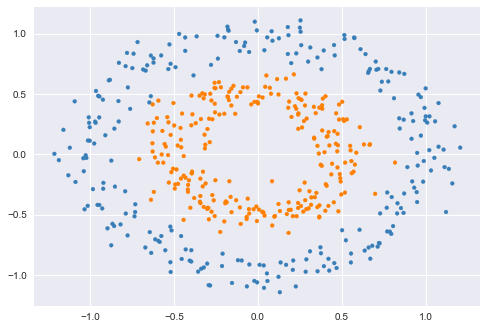

In [245]:
# Plotting the circle dataset
plt.scatter(x[:, 0], x[:, 1], s=15, color=mycolor[y_])

In [247]:
def myplot():
    x, y_ = datasets.make_circles(n_samples=500, noise=0.1, factor=0.5)
    y = np.reshape(y_, (len(y_),1))
    mycolor = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                             '#f781bf', '#a65628', '#984ea3',
                                             '#999999', '#e41a1c', '#dede00']),
                                      int(max(y_) + 1))))
    return plt.scatter(x[:, 0], x[:, 1], s=15, color=mycolor[y_])


In [43]:
# Create a basic MLP
class basic_MLP(nn.Module):
    def __init__(self):
        super(basic_MLP, self).__init__()
        self.fc1 = nn.Linear(2, 3)
        self.fc2 = nn.Linear(3, 2)
        
    def forward(self, x):
        # convert tensor (datset_size, 1, 2) --> (dataset_size, 1*2)
        #x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [114]:
# Our dataset class
class CircleDataset(torch.utils.data.Dataset):
    def __init__(self, n_samples=500, noise=0.09, factor=0.6):
        X_, Y_ = datasets.make_circles(n_samples=n_samples, noise=noise, factor=factor)
        Y__ = np.reshape(Y_, len(Y_))
        self.X = torch.tensor(X_, dtype=torch.float)
        self.Y = torch.tensor(Y__, dtype=torch.long)
        self.n_samples=n_samples

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        x = self.X[idx,:]
        y = self.Y[idx]
        return [x, y]

In [110]:
def compute_test_acc(model, test_loader):
    """
    Compute the accuracy on a test set
    """
    model.eval()
    correct = 0
    with no_grad():
        for data, target in test_loader:
            #data = data.double()
            #data = data.to(device)
            #target = target.to(device)
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    acc = correct / len(test_loader.dataset)
    print("Test accuracy =", acc)
    return acc

In [120]:
train_dataset = CircleDataset(100)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=10, shuffle=True)

test_dataset = CircleDataset(100)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=100, shuffle=True)

def training(model, train_loader, epochs=10, lr=0.1):
    print(train_loader)
    optimizer = optim.SGD(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(epochs):
        batch_val = 0
        myloss = 0
        for x_batch, y_batch in train_loader:
            batch_val += 1
            x_batch.requires_grad=True
            optimizer.zero_grad()
            output = model(x_batch)
            loss = criterion(x_batch, y_batch)
            myloss += loss
            loss.backward()
            optimizer.step()
        print(f"Loss = {myloss/batch_val}")
    return model

my_mlp = training(basic_MLP(), train_loader, 10, 0.1)
#my_mlp = basic_MLP()
compute_test_acc(my_mlp, test_loader)

Loss = 0.7931885123252869
Loss = 0.7931885123252869
Loss = 0.7931885123252869
Loss = 0.7931885123252869
Loss = 0.7931884527206421
Loss = 0.7931885719299316
Loss = 0.7931885123252869
Loss = 0.7931886315345764
Loss = 0.7931884527206421
Loss = 0.7931885719299316
Loss = 0.7931885123252869
Loss = 0.7931884527206421
Loss = 0.7931885719299316
Loss = 0.7931885719299316
Loss = 0.7931884527206421
Loss = 0.7931885719299316
Loss = 0.7931885123252869
Loss = 0.7931886315345764
Loss = 0.7931885719299316
Loss = 0.7931885123252869
Loss = 0.7931885123252869
Loss = 0.7931885123252869
Loss = 0.7931884527206421
Loss = 0.7931885719299316
Loss = 0.7931885123252869
Loss = 0.7931885123252869
Loss = 0.7931884527206421
Loss = 0.7931884527206421
Loss = 0.7931885123252869
Loss = 0.7931886315345764
Loss = 0.7931885719299316
Loss = 0.7931884527206421
Loss = 0.7931885719299316
Loss = 0.7931885719299316
Loss = 0.7931885123252869
Loss = 0.7931885123252869
Loss = 0.7931885123252869
Loss = 0.7931885123252869
Loss = 0.793

0.5

In [147]:
from operator import itemgetter
a = [torch.tensor([[1,  2]]), torch.tensor([[3,  4]])]
c = list(map(itemgetter(1), map(itemgetter(0), a)))
c

[tensor(2), tensor(4)]

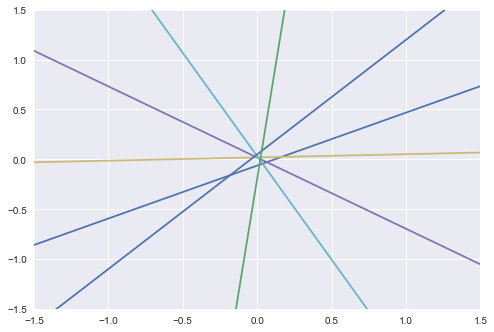

In [168]:
x = np.linspace(-1.5, 1.5, 21)
plt.plot(x, -0.2/3.2 + x*1.7/3.2, "-")
plt.plot(x, (-0.63 + x*(-0.37))/-0.01, "-")
plt.plot(x, (4.13 + x*(-0.17))/-0.32, "-")
plt.plot(x, (-0.06 + x*(2.5))/-3.5, "-")
plt.plot(x, (0.07 + x*(0.12))/3.7, "-")
plt.plot(x, (-0.04 + x*(2.8))/-1.35, "-")
plt.plot(x, (-0.1 + x*(-2.3))/-2, "-")
plt.plot(x, (0.09 + x*(-4.4))/-0.48, "-")
plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)
plt.show()

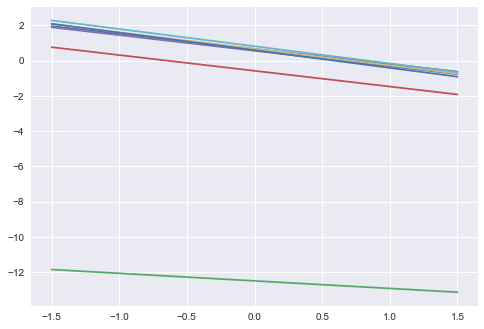

In [175]:
x = np.linspace(-1.5, 1.5, 21)
plt.plot(x, (-1.75 + x*2.28)/-2.65, "-")
plt.plot(x, (-1.75 + x*(-0.06))/0.14, "-")
plt.plot(x, (-1.75 + x*(-2.68))/3, "-")
plt.plot(x, (-1.75 + x*(2.8))/-3.16, "-")
plt.plot(x, (-1.75 + x*(2.46))/-2.63, "-")
plt.plot(x, (-1.75 + x*(2.11))/-2.16, "-")
plt.plot(x, (-1.75 + x*(3))/-3, "-")
#plt.xlim(0,0.5)
#plt.ylim(0,1)

In [233]:
w1 = np.matrix([[1,-1],[3,-1],[-1,5]])
w2 = np.matrix([[1],[3],[-5]])
x = np.matrix([[1],[1],[1]])
def output(x, w1=w1, w2=w2):
    x2 = [1]+x
    out1 = np.maximum(np.matmul(x2,w1), 0)
    out11 = np.concatenate((np.matrix([[1]]), out1), axis=1)
    out2 = np.matmul(out11, w2)
    return float(out2)

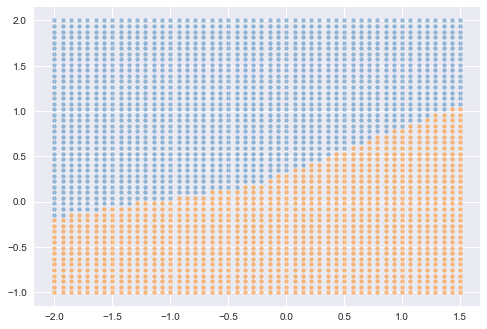

In [234]:
for x in np.linspace(-2,1.5,50):
    for y in np.linspace(-1,2,50):
        out = output([x,y])
        if out < 0:
            col = '#377eb8'
        else:
            col = '#ff7f00'
        plt.scatter(x, y, s=15, color=col, alpha=0.5)
plt.show()

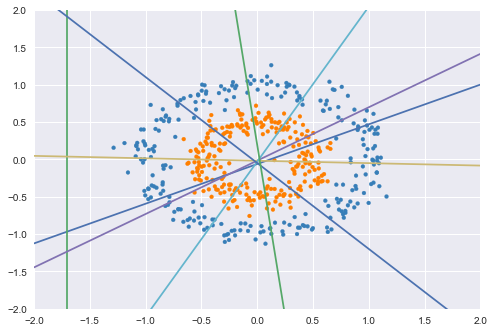

In [266]:
x = np.linspace(-2, 2, 30)
plt.plot(x, -0.2/3.2 + 1.7*x/3.2, "-")
plt.plot(x*0-0.63/0.37, x, "-")
plt.plot(x, 4.13/0.32 - 0.17*x/0.32, "-")
plt.plot(x, -0.06/3.5 + 2.5*x/3.5, "-")
plt.plot(x, -0.07/3.7 - 0.12*x/3.7, "-")
plt.plot(x, -0.04/1.35 + 2.8*x/1.35, "-")
plt.plot(x, -0.1/2 - 2.3*x/2, "-")
plt.plot(x, 0.09/0.48 - 4.4*x/0.48, "-")
myplot()
plt.xlim(-2,2)
plt.ylim(-2,2)
plt.show()

In [274]:
a = False
bs = [1,0,1,0]
for b in bs:
    if (a)*(b == 1) or (not a)*(b == 0):
        print(f"ok ! b={b}")

ok ! b=0
ok ! b=0


for 1 = (0.0, 1.0833333333333333, 2.0) and for 2 = (1.0, 3.6315789473684212, 6.0)
(2, 2)


<ErrorbarContainer object of 3 artists>

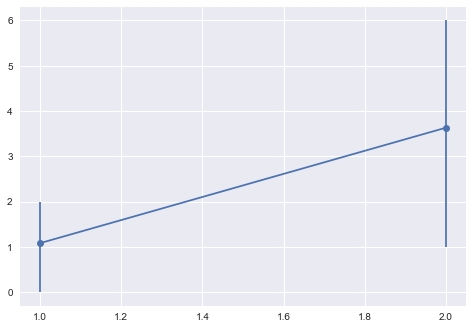

In [297]:
x1 = [1,2,1,1,3,2,1,0,0,1,0,1]
x2 = [4,4,4,5,6,1,2,5,6,3,3,2,4,1,1,3,4,5,6]
x3 = [8,8,9,7,8,6,7,8]

m1 = np.mean(x1)
qu1 = np.quantile(x1, 0.9)
qd1 = np.quantile(x1, 0.1)
m2 = np.mean(x2)
qu2 = np.quantile(x2, 0.9)
qd2 = np.quantile(x2, 0.1)
print(f"for 1 = {qd1, m1, qu1} and for 2 = {qd2, m2, qu2}")
err_ = np.array([[m1-qd1,m2-qd2],[qu1-m1,qu2-m2]])
print(err_.shape)
plt.errorbar([1,2], [m1,m2], yerr=err_, fmt="o-")

[[1.08  2.6  ]
 [0.916 2.3  ]] <class 'numpy.ndarray'> (2, 2)


<ErrorbarContainer object of 3 artists>

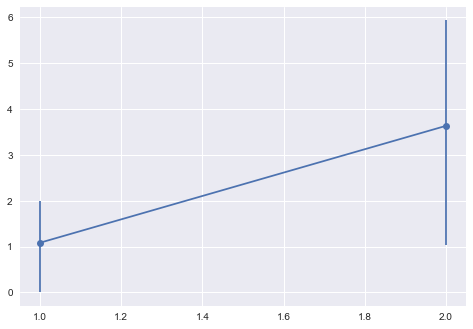

In [321]:
err_
a = [1.08, 0.916]
b = [2.6, 2.3]
d = [3.5, 3.3]
c = np.asarray(a+b).reshape(-1,2).T
print(c, type(c), c.shape)
plt.errorbar([1,2], [m1,m2], yerr=c, fmt="o-")

In [319]:
a = list()
b = [1,2]
c = [3,4]
a.append(b)
a.append(c)
np.asarray(a).reshape(-1,2).T

array([[1, 3],
       [2, 4]])